In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/realestatepriceprediction/sample_submission.csv
/kaggle/input/realestatepriceprediction/train.csv
/kaggle/input/realestatepriceprediction/test.csv


In [2]:
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Пути к файлам

In [3]:
PATH_TO_TRAIN = '/kaggle/input/realestatepriceprediction/train.csv'
PATH_TO_TEST = '/kaggle/input/realestatepriceprediction/test.csv'

# Описание данных

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

Не принципиально с точки зрения обработки данных, но Helthcare_2 явно должно нзываться Healthcare_2

# Начало работы с данными

In [4]:
ds_train = pd.read_csv(PATH_TO_TRAIN)
print(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Фичи LifeSquare и Healthcare_1 имеют пропуски  
Фичи Ecology_2, Ecology_3 и Shops_2 имеют тип object

In [5]:
ds_test = pd.read_csv(PATH_TO_TEST)
print(ds_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Фичи LifeSquare и Healthcare_1 имеют пропуски  
Фичи Ecology_2, Ecology_3 и Shops_2 имеют тип object

In [6]:
# Фича Id не имеет релевантного значения в предстоящем прогнозе, в связи с чем возможно выполнить:
ds_train['Id'] = ds_train['Id'].astype(str)
print(ds_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# 1. EDA

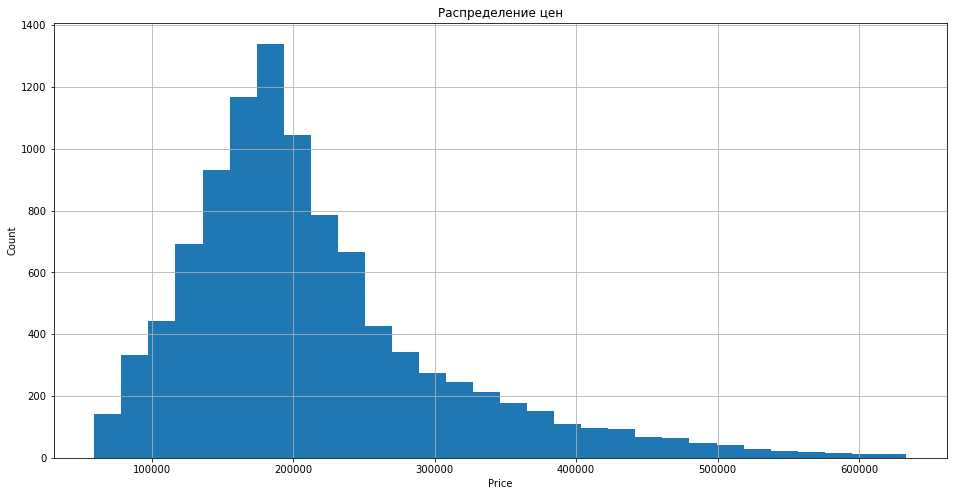

In [7]:
plt.figure(figsize = (16, 8))

ds_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Распределение цен')
plt.show()

Цена имеет нормальное рпспределение и, можно сказать, что выбросы отсутствуют.

### Определение количественных переменных

In [8]:
ds_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Фичи LifeSquare и Healthcare_1 имеют пропуски.

In [9]:
ds_train.select_dtypes(exclude='object').columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

### Определение номинативных переменных и их категоризация

In [10]:
ds_train.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [11]:
ds_train['Id'].value_counts()

12315    1
12949    1
12967    1
5780     1
11951    1
        ..
12358    1
4318     1
2317     1
15903    1
13825    1
Name: Id, Length: 10000, dtype: int64

Фичу Id возможно убрать из датасета, так как она не будет влиять на прогноз цены

In [12]:
ds_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [13]:
ds_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [14]:
ds_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# 2. Проверка данных на выбросы и подготовка обработки выбросов

In [15]:
ds_train['DistrictId'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Фича DistrictId может влиять на прогноз, так как цена может отличаться в зависимости от расположения недвижимости

In [16]:
ds_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
ds_train['Rooms'].median()

2.0

Видно, что присутствуют показатели фичи, существенно отличающиеся от медианы. В соответствии с этим, минимальное количество комнат будет принято за 1 и максимальное за 6.
Для отображения внесенных изменений надо создать фичу, которая отображает наличие выброса в строке (Rooms_outlier)

In [18]:
ds_train['Rooms_outlier'] = 0
ds_train.loc[(ds_train['Rooms'] == 0) | (ds_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [19]:
ds_train.loc[ds_train['Rooms']>=6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1


In [20]:
ds_train.loc[ds_train['Rooms']>=5, 'Price'].describe()

count        22.000000
mean     372063.185363
std      151785.712547
min       78364.616704
25%      276360.884330
50%      393471.656155
75%      477602.307377
max      622888.825328
Name: Price, dtype: float64

Для коррекции выбросов, будет использован принцип замены 0 количества комнта на 1, а больше 6, в следствии незначительного количества строк, будет заменены на mean датасета.

In [21]:
ds_train.loc[ds_train['Rooms']==0, 'Rooms'] = 1
ds_train.loc[ds_train['Rooms']>=6, 'Rooms'] = ds_train['Rooms'].median()

In [22]:
ds_train['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [23]:
ds_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [24]:
ds_train['KitchenSquare'].isna().sum()

0

In [25]:
ds_train['KitchenSquare'].quantile(.975), ds_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [26]:
ds_train.loc[ds_train['KitchenSquare']<1,'KitchenSquare'].value_counts()

0.0    697
Name: KitchenSquare, dtype: int64

Рассмотрение количества строк с площадью меньше 3 и 2 показало, что количество таких строк весьма велико, чтобы рассматривать их как выбросы. В связи с этим выбросом рассматривается только нулевая площадь.

In [27]:
ds_train['KitchenSquare_outlier'] = 0
ds_train.loc[(ds_train['KitchenSquare'] == 0) | \
             (ds_train['KitchenSquare']>ds_train['KitchenSquare'].quantile(.975)), \
             'KitchenSquare_outlier'] = 1
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.930730,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.450063,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.908524,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.227217,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531644,0,0


In [28]:
ds_train.loc[(ds_train['KitchenSquare']>ds_train['KitchenSquare'].quantile(.975)), \
             'KitchenSquare'] = ds_train['KitchenSquare'].median()

ds_train.loc[ds_train['KitchenSquare']==0, 'KitchenSquare'] = ds_train['KitchenSquare'].median()

In [29]:
ds_train['KitchenSquare'].value_counts()

1.0     2460
6.0     1924
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
3.0       22
2.0        4
Name: KitchenSquare, dtype: int64

In [30]:
ds_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [31]:
ds_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [32]:
(ds_train['Floor']>ds_train['HouseFloor']).sum()

1825

In [33]:
ds_train['HouseFloor_outlier'] = 0
ds_train.loc[ds_train['HouseFloor']==0, 'HouseFloor_outlier'] = 1
ds_train.loc[ds_train['Floor']>ds_train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [34]:
ds_train.loc[ds_train['HouseFloor']==0, 'HouseFloor'] = ds_train['HouseFloor'].median()
floor_outliers = ds_train.loc[ds_train['Floor']>ds_train['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [35]:
ds_train.loc[floor_outliers, 'Floor'] = ds_train.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))
(ds_train['Floor']>ds_train['HouseFloor']).sum()

0

In [36]:
ds_train['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [37]:
ds_train['HouseYear_outlier'] = 0
ds_train.loc[ds_train['HouseYear']>datetime.today().year, 'HouseYear_outlier'] = 1
ds_train.loc[ds_train['HouseYear']>datetime.today().year] = datetime.today().year

In [38]:
ds_train['LifeSquare_nan'] = ds_train['LifeSquare'].isna() * 1
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,NaN,0,11,B,184966.930730,0,0,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,0,0,0,0,0
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,229.0,1,3,B,220925.908524,0,1,0,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,0,0,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,0,0,0,0,0


In [39]:
ds_train.loc[ds_train['LifeSquare'].isna(), 'LifeSquare'] = \
ds_train.loc[ds_train['LifeSquare'].isna(), 'Square'] - \
ds_train.loc[ds_train['LifeSquare'].isna(), 'KitchenSquare'] - 3

In [40]:
# Не знаю как заполнить Healthcare_1, поэтому эта фича будет удалена
# Для себя не понял зачем перечислял действия выше, когда их можно было сразу вынести в отделный класс

# 3. Создание класса обрабатывающего данные

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.binary_to_numbers = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.binary_to_numbers = {'A': 0, 'B': 1}
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
     
        # KitchenSquare
        condition = (X['KitchenSquare'] == 0) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X['KithcenSquare_outlier'] = 0
        
        X.loc[condition, 'KithcenSquare_outlier'] = 1
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] == 0, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.today().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1.head()
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = (X['Square']<X['LifeSquare'])
                    
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'].apply(lambda x : random.uniform(4,x)) - 3
        
        # Ecology_2
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        
        # Ecology_3
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        
        # Shops_2
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
                
        X.fillna(self.medians, inplace=True)
        
        return X

# 4. Подготовка новых признаков

In [42]:
binary_to_numbers = {'A': 0, 'B': 1}

ds_train['Ecology_2'] = ds_train['Ecology_2'].replace(binary_to_numbers)
ds_train['Ecology_3'] = ds_train['Ecology_3'].replace(binary_to_numbers)
ds_train['Shops_2'] = ds_train['Shops_2'].replace(binary_to_numbers)

Не вижу смысла в дальнейшей категоризации, так как числовые значения могут быть категорезированы по самим числам

# 5. Анализ проделанного

In [43]:
all_features = ds_train.columns.tolist()
all_features

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan']

In [44]:
old_features = all_features[:-6]

new_features = all_features[-5:]

target_name = 'Price'

# 6. Разбиение

In [45]:
train_df = pd.read_csv(PATH_TO_TRAIN)
X_test = pd.read_csv(PATH_TO_TEST)


X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [47]:
(X_train['Square']<X_train['LifeSquare']).sum()
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [48]:
pp = DataPreprocessing()
pp.fit(X_train)

X_train = pp.transform(X_train)
X_valid = pp.transform(X_valid)
X_test = pp.transform(X_test)

X_train.shape, X_valid.shape, X_test.shape

((7000, 23), (3000, 23), (5000, 23))

In [49]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0, 0)

# 7. Построение модели

In [50]:
rf_model = RandomForestRegressor(random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [51]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.961
Test R2:	0.704


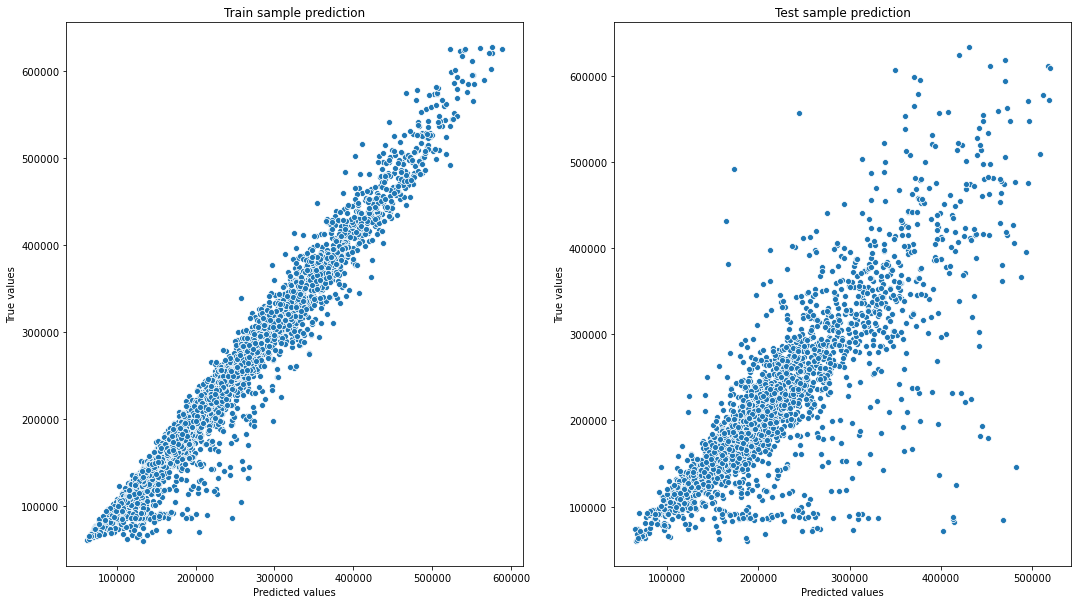

In [52]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс валидация

In [53]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', \
            cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.70801813, 0.71353726, 0.73774488])

Важность признаков

In [54]:
feature_importance = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), \
                                 columns=['features', 'importance'])
feature_importance.sort_values(by='importance', ascending=False)

,features,importance
3,Square,0.393021
13,Social_2,0.104160
12,Social_1,0.089970
2,Rooms,0.067857
14,Social_3,0.061211
1,DistrictId,0.052147
9,Ecology_1,0.041741
4,LifeSquare,0.034671
8,HouseYear,0.033585
0,Id,0.027849


Значимость признаков явно не соответствует реалиям рынка.
Модель будет переделана, в случае недостаточной точности прогнозирования.

# 8. Прогнозирование на тестовом датасете

In [55]:
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,KithcenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,0,0,1,0,0,0,0,0
1,15856,74,2.0,69.263183,65.263183,1.0,1,1.0,1977,0.075779,...,1437,3,0,2,1,0,0,1,0,1
2,5480,190,1.0,13.597819,6.517224,12.0,2,5.0,1909,0.000000,...,7538,87,5,5,1,0,0,0,0,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,3,3,1,0,0,0,0,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,0,0,0,0,0,0,0,0


In [56]:
submit = pd.read_csv('/kaggle/input/realestatepriceprediction/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [57]:
predictions = rf_model.predict(X_test)
predictions

array([162223.03443185, 220309.09446881, 196305.34640604, ...,
       303882.24488174, 190138.01239672, 181937.54782396])

In [58]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,162223.034432
1,15856,220309.094469
2,5480,196305.346406
3,15664,356726.098501
4,14275,139129.847532


In [59]:
submit.to_csv('rf_submit.csv', index=False)